# Big Tech Stock Predictor

The goal of this project is to use AAPL stock as a tool to leverage different machine learning and deep learning regressors to predict the stock price / movement across an array of intervals to see how accurate ML / DL models can be in forecasting prices.

**What is being predicted?**

The predicted feature is the adjusted close as this is the standard for comparing the price of a security regardless of security splits / other external factors, and thus this will be the target feature that the regressors will be trying to estimate.

**What are the considerations and insights needed for this project?**

*Time-Shift*

*  
Note also that the target variable - actual adj close - varies depending on the time frame we are trying to predict as it shifts depending on how far out we are attempting to forecast into the future.

*Leaking Future Information to Models*

*   Note also that it is important to be very intentional about how the data is partitioned, otherwise we can potentially leak future information about future adj close prices to the model, which can lead to overfitting and false predictive power. Thus, for all models where leakage is especially damaging (ie 1 year and 10 year predictions) this has been accounted for.

*Isn't predicting a decade out impossible?*

*  For all intensive purposes, yes. It is virtually impossible to accurately predict any security's price and account for market conditions years out. This is simply an experiment to see how the models perform after attempting to prevent all overfitting, info leakage, and other issues. I do find some interesting results that will be discussed at the end of the file.

*Is there a difference in the time series of what the traditional ML models are predicting and what the DL models are predicting?*

* Yes, the ML models predict both the next day adjusted close for earnings and non-earnings days, as well as both a month, year and decade in the future. The DL models focus exclusively on the next year / decade prediction, as these are more suitable tasks for the predictive power / visualization comparison I am going for.


# Data Pre-Processing

**Featuring Engineering?**

Note that feature engineering has already been performed manually on this dataset to add in extra columns, and thus the resulting CSV file is already engineered. I added in manually the column for Earnings (0 representing non-earnings the next day and 1 representing an earnings report the following day), and also predicted EPS (earnings per share) and actual EPS columns.

**Market Sentiment?**

I believe adding the EPS feature is crucial for model prediction, as it offers a view into the sentiment of the market at the time period, which is impossible to guage through metrics like high, low, etc.

**Citations**

Citation for AAPL stock inital data: https://www.kaggle.com/datasets/evangower/big-tech-stock-prices/?select=AAPL.csv

Citation for Earnings, Predicted and Actual EPS data: https://www.alphaquery.com/stock/AAPL/earnings-history

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Extract the timestamps from the datetime and convert it to float
df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

ModuleNotFoundError: No module named 'seaborn'

# Visualization of features

Just how correlated are our features exactly?

In [ ]:
correlation_matrix = df_aapl.corr()

plt.figure(figsize=(12, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

plt.title('Correlation Matrix of AAPL Stock Features')
plt.show()

NameError: name 'df_aapl' is not defined

# Linear Regression Model

**Next Day Prediction (non-earnings eve)**

Uses non-earnings eve rows (ie rows where the next day is not an earnings day) to forecast AAPL stock price predictions for the next day

Overall size of predictions for a day (non-earnings) out: 648
Overall modified Accuracy
0.9714710822533517
Mean Squared Error (adj price in dollars amount off): 1.8493376998687274
Custom Prediction for next day, actual adj close is 51.719452
Linear Regression model predicted for next day: [53.91617446]
Accuracy of Custom Prediction:
[95.75261846]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


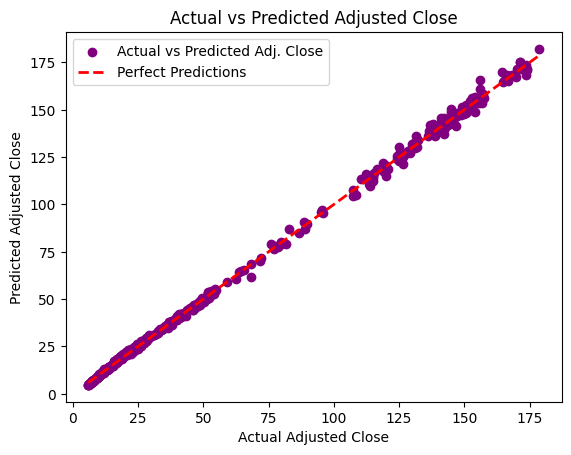

In [ ]:
# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler and apply to train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (non-earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next day, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next day: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Analysis of non-earnings eve results**

In the above graphs, we can see a very interested spread of our model's predictions. In the Actual vs Predicted Adjusted Close graph, we can see that the linear regression model is quite accurate at the start of the actual adjusted close price, but as the adjusted close price goes on (and thus time also increases due to correlation), we see that the model is less accurate with its predictions straying further from the perfect prediction trend line. This phenomena also extends to the accuracy of the cross-validated predictions as well, and can be best explained through the increase of market volatility over recent years.

Market volatility will likely become even more prevalent as time goes on, and thus is something that must be accounted for in making predictions. However, it is interesting that its visualization is readily apparent in the above graph.

**Next Day Prediction (earnings eve)**

Overall size of predictions for a day (earnings) out: 7
Overall modified Accuracy
0.9830830795503233
Mean Squared Error (adj price in dollars amount off): 4.685496522072697
Custom Prediction for next earnings day, actual adj close is 49.889595
Linear Regression model predicted for next earnings day: [53.71410941]
Accuracy of Custom Prediction:
[92.33404398]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


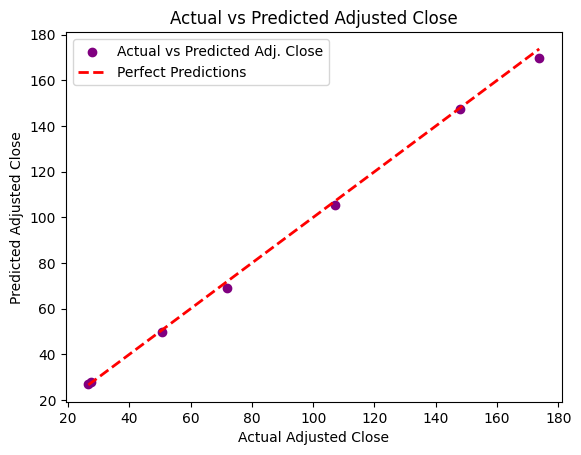

In [ ]:
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adjusted close (ie what we are trying to predict)
# to be the next day's adjusted close
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        pd.concat([selected_rows, row], ignore_index=True)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          next_row_df = pd.DataFrame(df_aapl.loc[index + 1]).transpose()
          selected_rows = pd.concat([selected_rows, next_row_df], ignore_index=True)

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler and apply to train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame or list of tuples with predicted and actual values
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_aapl, predicted)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 11/01/2018 predicting 11/02/2018 adj close)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next earnings day, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next earnings day: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

**Analysis of earnings eve results**

The Predicted Adjusted Close seems to be quite accurate, which is suspicious and could possibly be the result of data leakage to the Linear Regressor. This remains to be explored further.

**Next Month Stock Prediction (non-earnings)**

*Shift Value: 22 days*

Note that the shift for the monthly data is not quite as linear as simply shifting over by 1 for the subsequent day due to varying month length. Instead, an average has been taken between different months to use an approximation of the number of market open days that elaspses in a monthly interval. An approximation of 22 market open days between monthly intervals was found to best estimate this shift.


Overall size of predictions for a month out: 644
Overall modified Accuracy
0.9262956731848496
Mean Squared Error (adj price in dollars amount off): 32.575642016019934
Custom Prediction for next month, actual adj close is 131.159927
Linear Regression model predicted for next month: [147.94641016]
Accuracy of Custom Prediction:
[87.20151532]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


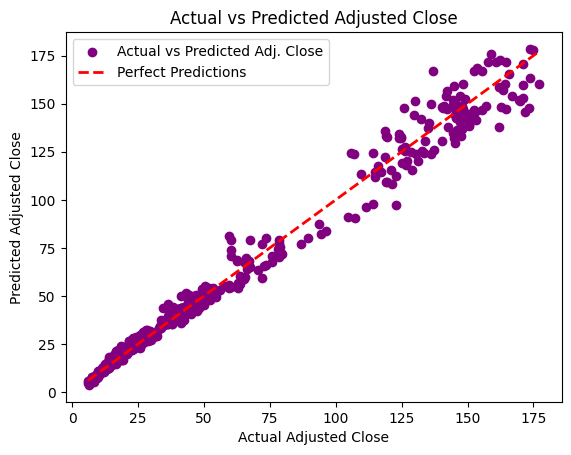

In [ ]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later to simulate a month
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-22)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler and apply to train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a month out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2022-05-17)
custom_values = np.array([[148.860001,149.770004,146.679993,149.240005,78336300,0]])

# This would be the date (2022-06-17)
actual_adj_value = 131.159927

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example (2022-05-17) predicting (2022-06-17)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next month, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next month: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Analysis of next Month prediction**

Once again you can readily see Market Volatility increase as time goes on.

**Next Year Stock Prediction (non-earnings)**

*Shift Value: 250 days*

To determine the 250 value as the proper amount to shift, I used the .tail() method to see the last values of the df, and adjusted the amount so that the tail end of the data cut off as close to 1 year earlier as possible, ensuring the closest possible business day shift for the dataset. Also manual testing was performed in Excel to ensure 250 provided a realistic shift to simulate a year.

This is relatively a suitable estimate, as Wikipedia states that on average, the NASDAQ and NYSE average [about 252 trading days in a year. ](https://en.wikipedia.org/wiki/Trading_day#:~:text=The%20NYSE%20and%20NASDAQ%20average%20about%20252%20trading%20days%20a%20year.)

*Train/Test Split*

Note that we also start splitting the data into training and test sets more intentionally now to prevent future data leakage.

Mean Squared Error (adj price in dollars amount off): 3009.948916051985
Custom Prediction for next year, actual adj close is 51.923771
Linear Regression model predicted for next year: [72.28806756]
Accuracy of Custom Prediction:
[60.78039755]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


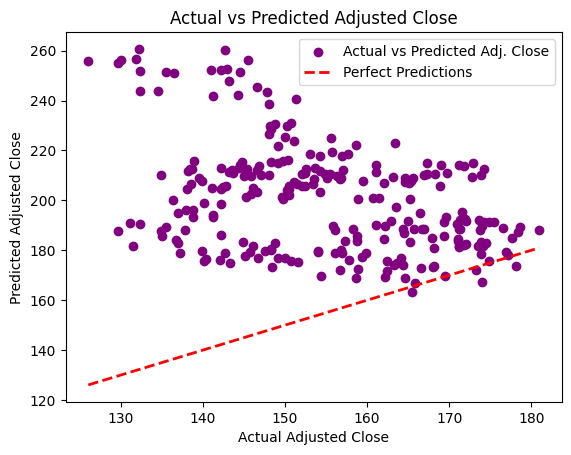

In [ ]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately one year (250 business market open) days later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-250)

# Drop the last row to handle NaN values created by the shift
df_aapl_non = df_aapl.dropna()

# Split the data into training and testing sets, giving us the date range for testing
# where start_date starts the training data, and end_date ends the training data
start_date = '2020-12-31'
end_date = '2021-12-31'

# Convert the date column to datetime format if needed
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < start_date]
test_set = df_aapl[(df_aapl['Date'] >= start_date) & (df_aapl['Date'] <= end_date)]

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

y_test = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Create a StandardScaler and apply to train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
custom_values = np.array([[54.200001,54.297501,53.507500,53.759998,104639200,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next year: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Analysis of next Year prediction**

It is pretty clear that the Linear Regressor model is not quite exactly picking up the trend in adjusted close price over the 2022 test year.

One interesting this, is that the Linear Regressor can't comprehend that the next year custom prediction value (from late August 2018 to August 2019) would actually decline over a year, as it tries to estimate

Linear Regression model predicted for next year: ~70

**Next Decade Stock Prediction (non-earnings)**

*Shift Value: 2520 days*

The 2520 value as the approximation for business days in a decade was found to be most suitable for this dataset using a similar method as the yearly shift estimate in the above cell using the .tail() method. This is also supported by the earlier reference that states [the typical trading year has 252 market open days in it.](https://en.wikipedia.org/wiki/Trading_day#:~:text=The%20NYSE%20and%20NASDAQ%20average%20about%20252%20trading%20days%20a%20year.)

train_set
          Date       Open       High        Low      Close  Adj Close  \
0   2010-01-04   7.622500   7.660714   7.585000   7.643214   6.515213   
1   2010-01-05   7.664286   7.699643   7.616071   7.656429   6.526476   
2   2010-01-06   7.656429   7.686786   7.526786   7.534643   6.422664   
3   2010-01-07   7.562500   7.571429   7.466071   7.520714   6.410790   
4   2010-01-08   7.510714   7.571429   7.466429   7.570714   6.453412   
..         ...        ...        ...        ...        ...        ...   
668 2012-08-27  24.285357  24.316786  24.055000  24.131430  20.658375   
669 2012-08-28  24.106428  24.146429  23.952499  24.100000  20.631475   
670 2012-08-29  24.116072  24.202499  24.021429  24.052500  20.590811   
671 2012-08-30  23.951429  23.983929  23.673214  23.709642  20.297300   
672 2012-08-31  23.830357  23.878571  23.473213  23.758572  20.339184   

        Volume  Earnings  Estimated EPS  Actual EPS  Target Adj Close  \
0    493729600         0            0.0 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Custom Prediction for next decade, actual adj close is 168.119446
Linear Regression model predicted for next decade: [152.07924152]
Accuracy of Custom Prediction:
[90.45904274]


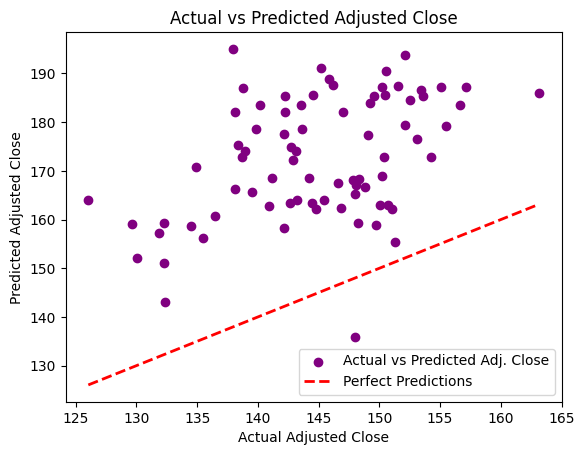

In [ ]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

df_aapl['Target Date'] = df_aapl['Date'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl_non = df_aapl.dropna()

# y_aapl = df_aapl_non['Target Adj Close']

# # Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# # since we are not considered earnings per share (EPS) estimates
# X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Specify the date to split the data
split_date = '2012-9-01'

# Convert the date column to datetime format if needed
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < split_date]
print("train_set")
print(train_set)
test_set = df_aapl[df_aapl['Date'] >= split_date]
print("test_set")
print(test_set)

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS', 'Target Date'], axis=1)

y_test_lr = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS', 'Target Date'], axis=1)

# Create a StandardScaler and scale train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)
df_aapl_total = pd.read_csv('AAPL.csv')
df_aapl_total = df_aapl_total.dropna(subset=['Date'])
X_aapl_total = df_aapl_total.drop(['Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Create a new value for all predictions
X_total_scaled = scaler.transform(X_aapl_total)

# Create a DataFrame with cross-validated predictions
results_df_lr = pd.DataFrame({'Predicted': predictions, 'Actual': y_test_lr})
results_df_lr = results_df_lr.dropna()

# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test_lr))

predictions_total = linear_regression_model.predict(X_total_scaled)
results_total_df_lr = pd.DataFrame({'Predicted': predictions_total})

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2012-02-14)
custom_values = np.array([[18.023571,18.198570,17.928572,18.195000,460398400,0]])

# This would be the date (2022-02-14)
actual_adj_value = 168.119446

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 2012-02-14 predicting 2022-02-14
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next decade, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df_lr['Actual'], results_df_lr['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df_lr['Actual'].min(), results_df_lr['Actual'].max()], [results_df_lr['Actual'].min(), results_df_lr['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Decade Prediction w/out Leakage Prevention

(and more data points)

Overall modified Accuracy
0.6871020506512903
Custom Prediction for next decade, actual adj close is 168.119446
Linear Regression model predicted for next decade: [382.67075869]
Accuracy of Custom Prediction:
[-27.61837955]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


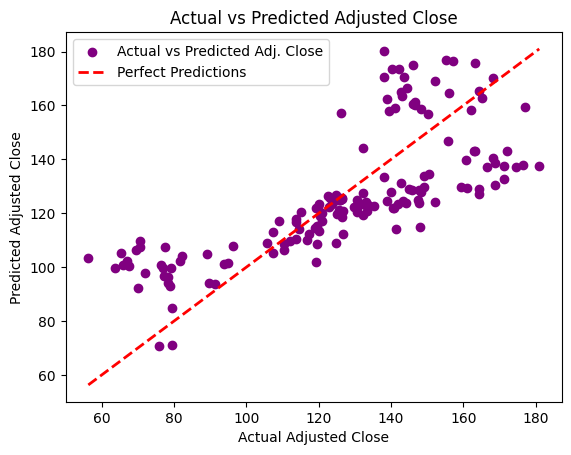

In [ ]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 2520 business (market open) days later to simulate a decade later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler and scale train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)
df_aapl_total = pd.read_csv('AAPL.csv')
df_aapl_total = df_aapl_total.dropna(subset=['Date'])
X_aapl_total = df_aapl_total.drop(['Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Create a new value for all predictions
X_total_scaled = scaler.transform(X_aapl_total)

# Create a DataFrame with cross-validated predictions
results_df_lr_fake = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
results_df_lr_fake = results_df_lr_fake.dropna()

# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test_lr))

predictions_total = linear_regression_model.predict(X_total_scaled)
results_total_df_lr = pd.DataFrame({'Predicted': predictions_total})

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2012-02-14)
# custom_values = np.array([[18.023571,18.198570,17.928572,18.195000,460398400,0]])

custom_values = np.array([[66.945000,68.139999,66.830002,67.864998,137310400,0]])


# This would be the date (2022-02-14)
actual_adj_value = 168.119446

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 2012-02-14 predicting 2022-02-14
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next decade, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df_lr_fake['Actual'], results_df_lr_fake['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df_lr_fake['Actual'].min(), results_df_lr_fake['Actual'].max()], [results_df_lr_fake['Actual'].min(), results_df_lr_fake['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

# Random Forest Regressor

**Next Day Prediction (non-earnings eve)**

Uses non-earnings eve rows (ie rows where the next day is not an earnings day) to forecast AAPL stock price predictions for the next day

MSE of RF Regressor (adj price in dollars amount off): 2.0060061182173756
2.0060061182173756
Overall size of predictions for a day (non-earnings) out: 648
Overall modified Accuracy
0.9834827371236702
Custom Prediction for next day, actual adj close is 51.719452
Random Forest model predicted for next day: [52.85712356]
Accuracy of Custom Prediction:
[97.80030237]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


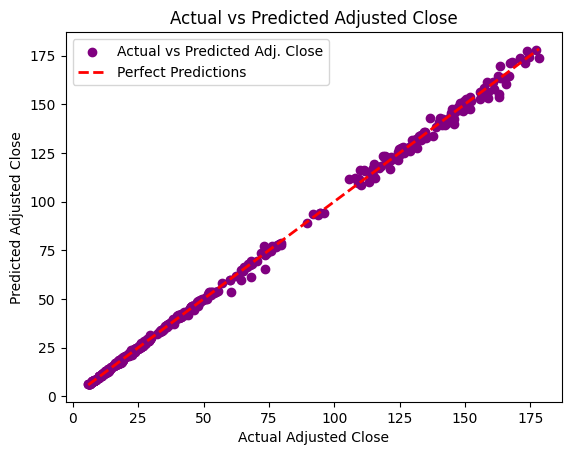

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (non-earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next day, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next day: {custom_predictions}")


print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Day Prediction (earnings eve)**
Uses earnings eve rows and subsequent earnings day rows as pairs to predict the earnings day adjusted price based upon earnings eve

MSE of RF Regressor (adj price in dollars amount off): 112.87816016830308
112.87816016830308
Overall size of predictions for a day out (earnings) out: 7
Overall modified Accuracy
0.8805950197970696
Accuracy of Custom Prediction:
[96.49077506]
Custom Prediction for next day (earnings), actual adj close is 49.889595
Random Forest model predicted for next day (earnings): [51.64033311]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


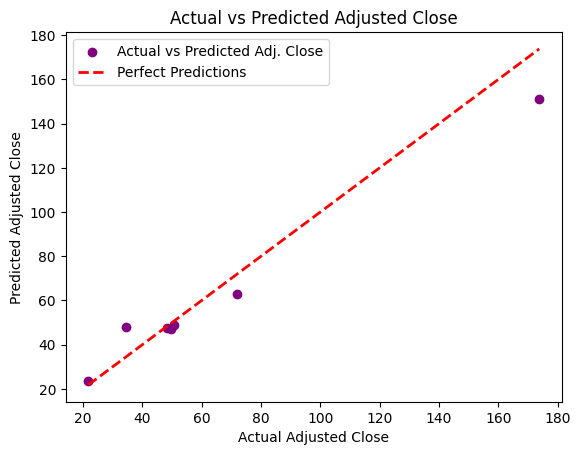

In [ ]:
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adjusted close (ie what we are trying to predict)
# to be the next day's adjusted close
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        pd.concat([selected_rows, row], ignore_index=True)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          next_row_df = pd.DataFrame(df_aapl.loc[index + 1]).transpose()
          selected_rows = pd.concat([selected_rows, next_row_df], ignore_index=True)

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))


print(f"Overall size of predictions for a day out (earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 11/01/2018 predicting 11/02/2018 adj close)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

print(f"Custom Prediction for next day (earnings), actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next day (earnings): {custom_predictions}")

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

**Next Month Prediction**

MSE of RF Regressor (adj price in dollars amount off): 30.694042823294158
30.694042823294158
Overall size of predictions for a month out: 644
Overall modified Accuracy
0.9314154624067206
Custom Prediction for next month, actual adj close is 131.159927
Random Forest model predicted for next month: [147.1526541]
Accuracy of Custom Prediction:
[87.80669717]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


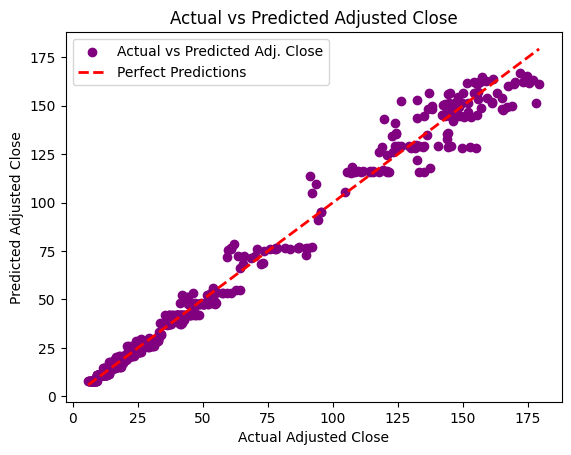

In [ ]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later to simulate a month later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-22)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a month out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2022-05-17)
custom_values = np.array([[148.860001,149.770004,146.679993,149.240005,78336300,0]])

# This would be the date (2022-06-17)
actual_adj_value = 131.159927

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the random forest regression model
# for our custom values (test example 2022-05-17 predicting 2022-06-17)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next month, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next month: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Year Prediction**

MSE of RF Regressor (adj price in dollars amount off): 67.21819456010245
67.21819456010245
Overall size of predictions for a year out: 599
Overall modified Accuracy
0.8776921857162144
Custom Prediction for next year, actual adj close is 51.923771
Random Forest model predicted for next year: [71.77180641]
Accuracy of Custom Prediction:
[61.774665]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


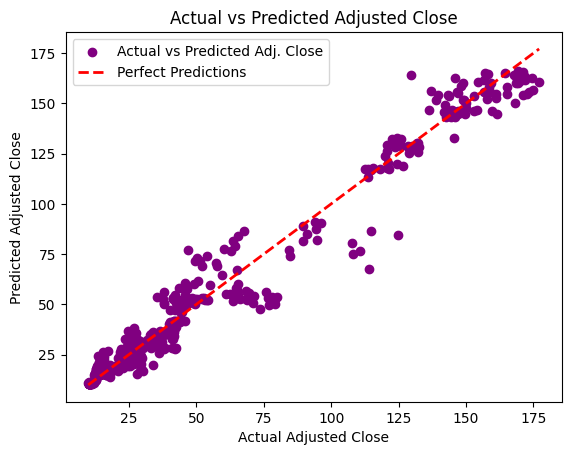

In [ ]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 250 business (market open) days later to simulate a year later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-250)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a year out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
custom_values = np.array([[54.200001,54.297501,53.507500,53.759998,104639200,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next year: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Decade Prediction**

MSE of RF Regressor (adj price in dollars amount off): 279.0301903716023
279.0301903716023
Overall size of predictions for a decade out: 143
Overall modified Accuracy
0.8983552315050247
Custom Prediction for next decade, actual adj close is 168.119446
Random Forest model predicted for next decade: [162.69638459]
Accuracy of Custom Prediction:
[96.77428071]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


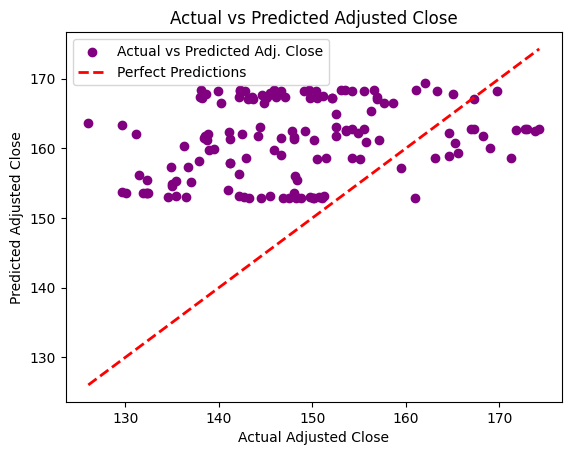

In [ ]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 2520 business (market open) days later to simulate a decade later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Specify the date to split the data
split_date = '2012-06-01'

# Convert the date column to datetime format
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < split_date]
test_set = df_aapl[df_aapl['Date'] >= split_date]

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

y_test = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a decade out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2012-02-14)
# custom_values = np.array([[18.023571,18.198570,17.928572,18.195000,460398400,0]])

custom_values = np.array([[66.945000,68.139999,66.830002,67.864998,137310400,0]])

# This would be the date (2022-02-14)
actual_adj_value = 168.119446

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2012-02-14 predicting 2022-02-14)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next decade, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# New Section

# Long-Short Term Memory

Epoch 1/12
4/4 [==============================] - 8s 653ms/step - loss: 1.0122 - val_loss: 0.7488
Epoch 2/12
4/4 [==============================] - 1s 241ms/step - loss: 1.0048 - val_loss: 0.7418
Epoch 3/12
4/4 [==============================] - 1s 231ms/step - loss: 1.0047 - val_loss: 0.7400
Epoch 4/12
4/4 [==============================] - 1s 226ms/step - loss: 1.0048 - val_loss: 0.7370
Epoch 5/12
4/4 [==============================] - 1s 229ms/step - loss: 1.0048 - val_loss: 0.7349
Epoch 6/12
4/4 [==============================] - 1s 233ms/step - loss: 1.0040 - val_loss: 0.7397
Epoch 7/12
4/4 [==============================] - 2s 401ms/step - loss: 1.0024 - val_loss: 0.7434
Epoch 8/12
4/4 [==============================] - 1s 300ms/step - loss: 1.0019 - val_loss: 0.7479
Epoch 9/12
4/4 [==============================] - 1s 230ms/step - loss: 1.0002 - val_loss: 0.7421
Epoch 10/12
4/4 [==============================] - 1s 231ms/step - loss: 0.9975 - val_loss: 0.7378
Epoch 11/12
4/4 [==

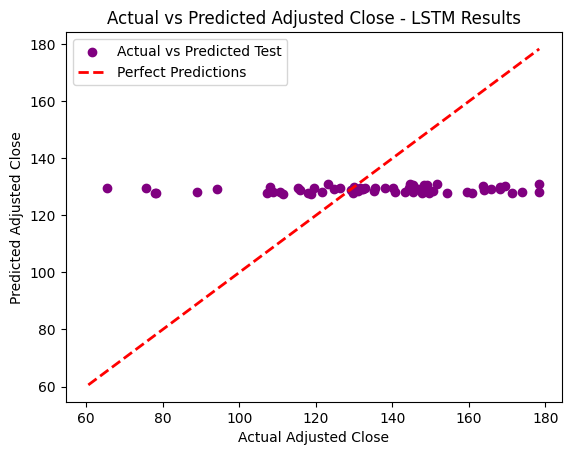

In [ ]:
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and actual EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considering earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Normalize the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input data to be 3D [samples, time steps, features]
time_steps = 90  # You can experiment with different time steps
X_train_reshaped = np.array([X_train_scaled[i:i+time_steps, :] for i in range(len(X_train_scaled)-time_steps+1)])
X_test_reshaped = np.array([X_test_scaled[i:i+time_steps, :] for i in range(len(X_test_scaled)-time_steps+1)])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train_reshaped.shape[2])))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train_scaled, epochs=12, batch_size=128, validation_split=0.1, verbose=1)

# Make predictions
train_predict = scaler_y.inverse_transform(model.predict(X_train_reshaped))
test_predict = scaler_y.inverse_transform(model.predict(X_test_reshaped))

# Calculate root mean squared error
train_rmse = np.sqrt(mean_squared_error(y_train.values[time_steps:], train_predict[:len(y_train) - time_steps]))
test_rmse = np.sqrt(mean_squared_error(y_test.values[time_steps:], test_predict[:len(y_test) - time_steps]))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

# Combine the training and testing predictions with the original data
all_predictions = np.concatenate([train_predict, test_predict])
all_actuals = np.concatenate([y_train.values[time_steps:], y_test.values[time_steps:]])

# Plot the actual difference between the predicted and actual adjusted close for testing data
plt.scatter(y_test.values[time_steps:], test_predict[:len(y_test) - time_steps], color='purple', label='Actual vs Predicted Test')

# Plot a diagonal line representing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close - LSTM Results')
plt.legend()
plt.show()

# Support Vector Regression (SVR)

What is train set:           Date       Open       High        Low      Close  Adj Close  \
0   2010-01-04   7.622500   7.660714   7.585000   7.643214   6.515213   
1   2010-01-05   7.664286   7.699643   7.616071   7.656429   6.526476   
2   2010-01-06   7.656429   7.686786   7.526786   7.534643   6.422664   
3   2010-01-07   7.562500   7.571429   7.466071   7.520714   6.410790   
4   2010-01-08   7.510714   7.571429   7.466429   7.570714   6.453412   
..         ...        ...        ...        ...        ...        ...   
603 2012-05-24  20.566786  20.589287  20.043928  20.190001  17.210320   
604 2012-05-25  20.163929  20.208929  19.945356  20.081785  17.118074   
605 2012-05-29  20.389286  20.500000  20.189644  20.438213  17.421902   
606 2012-05-30  20.328571  20.713928  20.234285  20.684643  17.631958   
607 2012-05-31  20.740713  20.767857  20.409286  20.633215  17.588123   

        Volume  Earnings  Estimated EPS  Actual EPS  Target Adj Close  
0    493729600         0        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


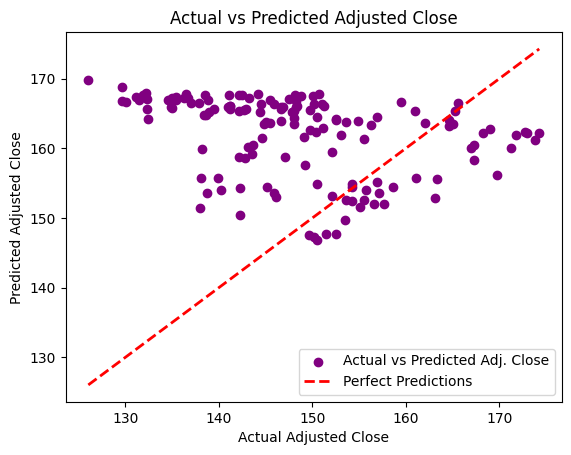

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Specify the date to split the data
split_date = '2012-06-01'

# Convert the date column to datetime format if needed
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < split_date]
print(f"What is train set: {train_set}")
test_set = df_aapl[df_aapl['Date'] >= split_date]
print(f"What is test set: {test_set}")

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

y_test = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)


# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# SVR model
svr = SVR()

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1],
              'kernel': ['linear', 'rbf', 'poly'],
              'epsilon': [0.1, 0.2, 0.5],
              'degree': [2, 3, 4]}

grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train SVR model with best hyperparameters
best_svr = SVR(**best_params)
best_svr.fit(X_train_scaled, y_train)

# Make predictions
predictions = best_svr.predict(X_test_scaled)

# Calculate root mean squared error
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a year out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
custom_values = np.array([[139.899994,141.350006,138.220001,138.979996,77033700,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = best_svr.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"SVR model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Feedforward Neural Network

Epoch 1/150
 1/22 [>.............................] - ETA: 26s - loss: 16122.6367

22/22 [==============================] - 1s 2ms/step - loss: 17332.0098
Epoch 2/150
 1/22 [>.............................] - ETA: 0s - loss: 18860.9492

22/22 [==============================] - 0s 2ms/step - loss: 17289.4551
Epoch 3/150
 1/22 [>.............................] - ETA: 0s - loss: 17495.0664

22/22 [==============================] - 0s 2ms/step - loss: 17235.3281
Epoch 4/150
 1/22 [>.............................] - ETA: 0s - loss: 15225.0859

22/22 [==============================] - 0s 2ms/step - loss: 17181.4238
Epoch 5/150
 1/22 [>.............................] - ETA: 0s - loss: 19530.7188

22/22 [==============================] - 0s 2ms/step - loss: 17118.8340
Epoch 6/150
 1/22 [>.............................] - ETA: 0s - loss: 16467.2012

22/22 [==============================] - 0s 2ms/step - loss: 17015.4453
Epoch 7/150
 1/22 [>.............................] - ETA: 0s - loss: 17873.9355

22/22 [==============================] - 0s 2ms/step - loss: 16892.2129
Epoch 8/150
 1/22 [>.............................] - ETA: 0s - loss: 17937.0332

22/22 [==============================] - 0s 2ms/step - loss: 16697.3184
Epoch 9/150
 1/22 [>.............................] - ETA: 0s - loss: 15065.7910

22/22 [==============================] - 0s 2ms/step - loss: 16527.8340
Epoch 10/150
 1/22 [>.............................] - ETA: 0s - loss: 17505.6914

22/22 [==============================] - 0s 2ms/step - loss: 16177.1709
Epoch 11/150
 1/22 [>.............................] - ETA: 0s - loss: 16309.5186

22/22 [==============================] - 0s 2ms/step - loss: 15775.3252
Epoch 12/150
 1/22 [>.............................] - ETA: 0s - loss: 14288.9316

22/22 [==============================] - 0s 2ms/step - loss: 15159.1768
Epoch 13/150
 1/22 [>.............................] - ETA: 0s - loss: 14882.0615

22/22 [==============================] - 0s 2ms/step - loss: 14619.2881
Epoch 14/150
 1/22 [>.............................] - ETA: 0s - loss: 15658.9180

22/22 [==============================] - 0s 2ms/step - loss: 13801.0176
Epoch 15/150
 1/22 [>.............................] - ETA: 0s - loss: 13937.4482

22/22 [==============================] - 0s 2ms/step - loss: 12700.7842
Epoch 16/150
 1/22 [>.............................] - ETA: 0s - loss: 13176.3379

22/22 [==============================] - 0s 2ms/step - loss: 11454.5566
Epoch 17/150
 1/22 [>.............................] - ETA: 0s - loss: 9640.1748

22/22 [==============================] - 0s 2ms/step - loss: 10460.5703
Epoch 18/150
 1/22 [>.............................] - ETA: 0s - loss: 9392.1650

22/22 [==============================] - 0s 2ms/step - loss: 9500.0742
Epoch 19/150
 1/22 [>.............................] - ETA: 0s - loss: 8491.8594

22/22 [==============================] - 0s 2ms/step - loss: 8174.2119
Epoch 20/150
 1/22 [>.............................] - ETA: 0s - loss: 7981.6597

22/22 [==============================] - 0s 2ms/step - loss: 7242.8018
Epoch 21/150
 1/22 [>.............................] - ETA: 0s - loss: 7692.2466

22/22 [==============================] - 0s 2ms/step - loss: 6450.0869
Epoch 22/150
 1/22 [>.............................] - ETA: 0s - loss: 7183.2129

22/22 [==============================] - 0s 2ms/step - loss: 5975.7480
Epoch 23/150
 1/22 [>.............................] - ETA: 0s - loss: 5348.5957

22/22 [==============================] - 0s 2ms/step - loss: 5941.6621
Epoch 24/150
 1/22 [>.............................] - ETA: 0s - loss: 5938.7715

22/22 [==============================] - 0s 2ms/step - loss: 5502.4824
Epoch 25/150
 1/22 [>.............................] - ETA: 0s - loss: 3570.8906

22/22 [==============================] - 0s 2ms/step - loss: 5248.7300
Epoch 26/150
 1/22 [>.............................] - ETA: 0s - loss: 4507.8862

22/22 [==============================] - 0s 2ms/step - loss: 5063.8804
Epoch 27/150
 1/22 [>.............................] - ETA: 0s - loss: 4574.8301

22/22 [==============================] - 0s 2ms/step - loss: 5008.0254
Epoch 28/150
 1/22 [>.............................] - ETA: 0s - loss: 4246.2676

22/22 [==============================] - 0s 2ms/step - loss: 4816.6694
Epoch 29/150
 1/22 [>.............................] - ETA: 0s - loss: 6150.6636

22/22 [==============================] - 0s 2ms/step - loss: 4794.7637
Epoch 30/150
 1/22 [>.............................] - ETA: 0s - loss: 3148.3450

22/22 [==============================] - 0s 2ms/step - loss: 4704.6826
Epoch 31/150
 1/22 [>.............................] - ETA: 0s - loss: 4226.3647

22/22 [==============================] - 0s 2ms/step - loss: 4461.7583
Epoch 32/150
 1/22 [>.............................] - ETA: 0s - loss: 2874.3062

22/22 [==============================] - 0s 2ms/step - loss: 4302.0391
Epoch 33/150
 1/22 [>.............................] - ETA: 0s - loss: 4136.4150

22/22 [==============================] - 0s 2ms/step - loss: 4029.5364
Epoch 34/150
 1/22 [>.............................] - ETA: 0s - loss: 4812.2002

22/22 [==============================] - 0s 2ms/step - loss: 4141.2808
Epoch 35/150
 1/22 [>.............................] - ETA: 0s - loss: 4249.2891

22/22 [==============================] - 0s 2ms/step - loss: 3884.9287
Epoch 36/150
 1/22 [>.............................] - ETA: 0s - loss: 3197.4844

22/22 [==============================] - 0s 2ms/step - loss: 3925.1882
Epoch 37/150
 1/22 [>.............................] - ETA: 0s - loss: 4012.9250

22/22 [==============================] - 0s 2ms/step - loss: 3863.7380
Epoch 38/150
 1/22 [>.............................] - ETA: 0s - loss: 5362.5034

22/22 [==============================] - 0s 2ms/step - loss: 3945.7712
Epoch 39/150
 1/22 [>.............................] - ETA: 0s - loss: 4030.1265

22/22 [==============================] - 0s 2ms/step - loss: 3805.3604
Epoch 40/150
 1/22 [>.............................] - ETA: 0s - loss: 2576.3682

22/22 [==============================] - 0s 2ms/step - loss: 3631.7485
Epoch 41/150
 1/22 [>.............................] - ETA: 0s - loss: 3153.0422

22/22 [==============================] - 0s 2ms/step - loss: 3520.7830
Epoch 42/150
 1/22 [>.............................] - ETA: 0s - loss: 3111.5701

22/22 [==============================] - 0s 2ms/step - loss: 3637.6226
Epoch 43/150
 1/22 [>.............................] - ETA: 0s - loss: 3426.4014

22/22 [==============================] - 0s 2ms/step - loss: 3366.9153
Epoch 44/150
 1/22 [>.............................] - ETA: 0s - loss: 3127.6335

22/22 [==============================] - 0s 2ms/step - loss: 3376.2378
Epoch 45/150
22/22 [==============================] - ETA: 0s - loss: 3406.9302

22/22 [==============================] - 0s 3ms/step - loss: 3406.9302
Epoch 46/150
 1/22 [>.............................] - ETA: 0s - loss: 4789.2173

22/22 [==============================] - 0s 2ms/step - loss: 3110.1528
Epoch 47/150
 1/22 [>.............................] - ETA: 0s - loss: 4175.8008

22/22 [==============================] - 0s 2ms/step - loss: 3444.8596
Epoch 48/150
 1/22 [>.............................] - ETA: 0s - loss: 3959.0151

22/22 [==============================] - 0s 2ms/step - loss: 3130.1753
Epoch 49/150
 1/22 [>.............................] - ETA: 0s - loss: 3623.2085

22/22 [==============================] - 0s 2ms/step - loss: 3000.5212
Epoch 50/150
 1/22 [>.............................] - ETA: 0s - loss: 4480.8574

22/22 [==============================] - 0s 2ms/step - loss: 3149.2307
Epoch 51/150
 1/22 [>.............................] - ETA: 0s - loss: 2319.3740

22/22 [==============================] - 0s 2ms/step - loss: 3216.7373
Epoch 52/150
 1/22 [>.............................] - ETA: 0s - loss: 2962.1470

22/22 [==============================] - 0s 2ms/step - loss: 3198.6931
Epoch 53/150
 1/22 [>.............................] - ETA: 0s - loss: 3444.2749

22/22 [==============================] - 0s 2ms/step - loss: 3174.3452
Epoch 54/150
 1/22 [>.............................] - ETA: 0s - loss: 2691.6848

22/22 [==============================] - 0s 2ms/step - loss: 2836.8093
Epoch 55/150
 1/22 [>.............................] - ETA: 0s - loss: 3077.1504

22/22 [==============================] - 0s 2ms/step - loss: 2964.5015
Epoch 56/150
 1/22 [>.............................] - ETA: 0s - loss: 2593.0618

22/22 [==============================] - 0s 2ms/step - loss: 3051.3181
Epoch 57/150
 1/22 [>.............................] - ETA: 0s - loss: 1925.2494

22/22 [==============================] - 0s 2ms/step - loss: 2883.1743
Epoch 58/150
 1/22 [>.............................] - ETA: 0s - loss: 3011.2988

22/22 [==============================] - 0s 2ms/step - loss: 3064.7280
Epoch 59/150
 1/22 [>.............................] - ETA: 0s - loss: 2988.9761

22/22 [==============================] - 0s 2ms/step - loss: 2777.3948
Epoch 60/150
 1/22 [>.............................] - ETA: 0s - loss: 2508.7593

22/22 [==============================] - 0s 2ms/step - loss: 2931.2188
Epoch 61/150
 1/22 [>.............................] - ETA: 0s - loss: 2465.6445

22/22 [==============================] - 0s 2ms/step - loss: 2731.4866
Epoch 62/150
 1/22 [>.............................] - ETA: 0s - loss: 2626.6782

22/22 [==============================] - 0s 2ms/step - loss: 2845.1094
Epoch 63/150
22/22 [==============================] - ETA: 0s - loss: 2621.7007

22/22 [==============================] - 0s 3ms/step - loss: 2621.7007
Epoch 64/150
 1/22 [>.............................] - ETA: 0s - loss: 2564.0190

22/22 [==============================] - 0s 2ms/step - loss: 2841.4910
Epoch 65/150
 1/22 [>.............................] - ETA: 0s - loss: 1395.5837

22/22 [==============================] - 0s 2ms/step - loss: 2819.3513
Epoch 66/150
 1/22 [>.............................] - ETA: 0s - loss: 3149.6167

22/22 [==============================] - 0s 2ms/step - loss: 3004.0962
Epoch 67/150
 1/22 [>.............................] - ETA: 0s - loss: 2892.2119

22/22 [==============================] - 0s 2ms/step - loss: 2677.7139
Epoch 68/150
 1/22 [>.............................] - ETA: 0s - loss: 2011.9260

22/22 [==============================] - 0s 2ms/step - loss: 2567.0752
Epoch 69/150
 1/22 [>.............................] - ETA: 0s - loss: 3574.8936

22/22 [==============================] - 0s 3ms/step - loss: 2485.9065
Epoch 70/150
 1/22 [>.............................] - ETA: 0s - loss: 4126.4766

22/22 [==============================] - 0s 2ms/step - loss: 2637.2542
Epoch 71/150
 1/22 [>.............................] - ETA: 0s - loss: 2719.2561

22/22 [==============================] - 0s 2ms/step - loss: 2670.0266
Epoch 72/150
 1/22 [>.............................] - ETA: 0s - loss: 2576.1899

22/22 [==============================] - 0s 2ms/step - loss: 2391.3499
Epoch 73/150
 1/22 [>.............................] - ETA: 0s - loss: 3324.3064

22/22 [==============================] - 0s 2ms/step - loss: 2468.2788
Epoch 74/150
17/22 [======================>.......] - ETA: 0s - loss: 2791.8708

22/22 [==============================] - 0s 4ms/step - loss: 2833.2908
Epoch 75/150
17/22 [======================>.......] - ETA: 0s - loss: 2737.8940

22/22 [==============================] - 0s 4ms/step - loss: 2673.5881
Epoch 76/150
21/22 [===========================>..] - ETA: 0s - loss: 2546.2905

22/22 [==============================] - 0s 3ms/step - loss: 2561.4092
Epoch 77/150
14/22 [==================>...........] - ETA: 0s - loss: 2773.8247

22/22 [==============================] - 0s 4ms/step - loss: 2757.2183
Epoch 78/150
21/22 [===========================>..] - ETA: 0s - loss: 2733.1929

22/22 [==============================] - 0s 3ms/step - loss: 2733.1572
Epoch 79/150
14/22 [==================>...........] - ETA: 0s - loss: 2638.4800

22/22 [==============================] - 0s 4ms/step - loss: 2546.2571
Epoch 80/150
17/22 [======================>.......] - ETA: 0s - loss: 2549.2297

22/22 [==============================] - 0s 4ms/step - loss: 2623.5955
Epoch 81/150
19/22 [========================>.....] - ETA: 0s - loss: 2336.3340

22/22 [==============================] - 0s 3ms/step - loss: 2452.9019
Epoch 82/150
21/22 [===========================>..] - ETA: 0s - loss: 2422.6843

22/22 [==============================] - 0s 3ms/step - loss: 2419.1606
Epoch 83/150
20/22 [==========================>...] - ETA: 0s - loss: 2366.6990

22/22 [==============================] - 0s 3ms/step - loss: 2397.8540
Epoch 84/150
17/22 [======================>.......] - ETA: 0s - loss: 2340.2754

22/22 [==============================] - 0s 4ms/step - loss: 2321.1584
Epoch 85/150
17/22 [======================>.......] - ETA: 0s - loss: 2458.7197

22/22 [==============================] - 0s 3ms/step - loss: 2410.4487
Epoch 86/150
20/22 [==========================>...] - ETA: 0s - loss: 2398.5559

22/22 [==============================] - 0s 3ms/step - loss: 2426.2068
Epoch 87/150
19/22 [========================>.....] - ETA: 0s - loss: 2476.9309

22/22 [==============================] - 0s 3ms/step - loss: 2459.1418
Epoch 88/150
20/22 [==========================>...] - ETA: 0s - loss: 2350.9468

22/22 [==============================] - 0s 3ms/step - loss: 2298.3589
Epoch 89/150
21/22 [===========================>..] - ETA: 0s - loss: 2509.4255

22/22 [==============================] - 0s 3ms/step - loss: 2505.7986
Epoch 90/150
20/22 [==========================>...] - ETA: 0s - loss: 2402.5815

22/22 [==============================] - 0s 3ms/step - loss: 2419.5415
Epoch 91/150
19/22 [========================>.....] - ETA: 0s - loss: 2444.8169

22/22 [==============================] - 0s 3ms/step - loss: 2422.6631
Epoch 92/150
21/22 [===========================>..] - ETA: 0s - loss: 2468.6204

22/22 [==============================] - 0s 3ms/step - loss: 2473.6355
Epoch 93/150
19/22 [========================>.....] - ETA: 0s - loss: 2639.9590

22/22 [==============================] - 0s 3ms/step - loss: 2688.5942
Epoch 94/150
13/22 [================>.............] - ETA: 0s - loss: 2400.7471

22/22 [==============================] - 0s 4ms/step - loss: 2389.9995
Epoch 95/150
20/22 [==========================>...] - ETA: 0s - loss: 2841.6941

22/22 [==============================] - 0s 3ms/step - loss: 2818.1182
Epoch 96/150
19/22 [========================>.....] - ETA: 0s - loss: 2561.8696

22/22 [==============================] - 0s 3ms/step - loss: 2489.8909
Epoch 97/150
19/22 [========================>.....] - ETA: 0s - loss: 2368.4902

22/22 [==============================] - 0s 3ms/step - loss: 2292.2913
Epoch 98/150
15/22 [===================>..........] - ETA: 0s - loss: 2360.2373

22/22 [==============================] - 0s 4ms/step - loss: 2360.0085
Epoch 99/150
18/22 [=======================>......] - ETA: 0s - loss: 2438.0254

22/22 [==============================] - 0s 3ms/step - loss: 2498.8923
Epoch 100/150
17/22 [======================>.......] - ETA: 0s - loss: 2443.2720

22/22 [==============================] - 0s 3ms/step - loss: 2419.2278
Epoch 101/150
18/22 [=======================>......] - ETA: 0s - loss: 2646.7117

22/22 [==============================] - 0s 3ms/step - loss: 2673.6064
Epoch 102/150
19/22 [========================>.....] - ETA: 0s - loss: 2221.4280

22/22 [==============================] - 0s 3ms/step - loss: 2281.6548
Epoch 103/150
19/22 [========================>.....] - ETA: 0s - loss: 2354.2820

22/22 [==============================] - 0s 3ms/step - loss: 2434.4114
Epoch 104/150
19/22 [========================>.....] - ETA: 0s - loss: 2353.9814

22/22 [==============================] - 0s 3ms/step - loss: 2292.2778
Epoch 105/150
18/22 [=======================>......] - ETA: 0s - loss: 2145.0093

22/22 [==============================] - 0s 3ms/step - loss: 2281.4871
Epoch 106/150
19/22 [========================>.....] - ETA: 0s - loss: 2129.1838

22/22 [==============================] - 0s 4ms/step - loss: 2227.1978
Epoch 107/150
16/22 [====================>.........] - ETA: 0s - loss: 2468.1111

22/22 [==============================] - 0s 4ms/step - loss: 2392.1101
Epoch 108/150
16/22 [====================>.........] - ETA: 0s - loss: 2180.7383

22/22 [==============================] - 0s 4ms/step - loss: 2182.2349
Epoch 109/150
18/22 [=======================>......] - ETA: 0s - loss: 2278.1243

22/22 [==============================] - 0s 3ms/step - loss: 2334.0330
Epoch 110/150
15/22 [===================>..........] - ETA: 0s - loss: 2155.5984

22/22 [==============================] - 0s 4ms/step - loss: 2210.0017
Epoch 111/150
20/22 [==========================>...] - ETA: 0s - loss: 2087.0562

22/22 [==============================] - 0s 3ms/step - loss: 2054.8948
Epoch 112/150
18/22 [=======================>......] - ETA: 0s - loss: 2273.1755

22/22 [==============================] - 0s 4ms/step - loss: 2254.7056
Epoch 113/150
15/22 [===================>..........] - ETA: 0s - loss: 2223.5466

22/22 [==============================] - 0s 4ms/step - loss: 2209.0430
Epoch 114/150
16/22 [====================>.........] - ETA: 0s - loss: 2270.0989

22/22 [==============================] - 0s 4ms/step - loss: 2218.2080
Epoch 115/150
20/22 [==========================>...] - ETA: 0s - loss: 2136.0061

22/22 [==============================] - 0s 3ms/step - loss: 2165.4001
Epoch 116/150
18/22 [=======================>......] - ETA: 0s - loss: 2234.4370

22/22 [==============================] - 0s 3ms/step - loss: 2286.9246
Epoch 117/150
18/22 [=======================>......] - ETA: 0s - loss: 1993.4878

22/22 [==============================] - 0s 3ms/step - loss: 1956.8914
Epoch 118/150
 1/22 [>.............................] - ETA: 0s - loss: 4009.6460

22/22 [==============================] - 0s 2ms/step - loss: 2213.9753
Epoch 119/150
 1/22 [>.............................] - ETA: 0s - loss: 2036.6028

22/22 [==============================] - 0s 2ms/step - loss: 2088.6309
Epoch 120/150
20/22 [==========================>...] - ETA: 0s - loss: 2349.6213

22/22 [==============================] - 0s 3ms/step - loss: 2335.2673
Epoch 121/150
 1/22 [>.............................] - ETA: 0s - loss: 2562.0693

22/22 [==============================] - 0s 2ms/step - loss: 2239.0793
Epoch 122/150
20/22 [==========================>...] - ETA: 0s - loss: 2151.0007

22/22 [==============================] - 0s 3ms/step - loss: 2159.7725
Epoch 123/150
 1/22 [>.............................] - ETA: 0s - loss: 3072.2427

22/22 [==============================] - 0s 2ms/step - loss: 2127.1619
Epoch 124/150
21/22 [===========================>..] - ETA: 0s - loss: 2015.6193

22/22 [==============================] - 0s 3ms/step - loss: 2013.1924
Epoch 125/150
 1/22 [>.............................] - ETA: 0s - loss: 1735.3689

22/22 [==============================] - 0s 2ms/step - loss: 2101.4067
Epoch 126/150
 1/22 [>.............................] - ETA: 0s - loss: 1875.9595

22/22 [==============================] - 0s 2ms/step - loss: 1958.4454
Epoch 127/150
 1/22 [>.............................] - ETA: 0s - loss: 1477.3647

22/22 [==============================] - 0s 2ms/step - loss: 2134.8071
Epoch 128/150
 1/22 [>.............................] - ETA: 0s - loss: 2006.7913

22/22 [==============================] - 0s 2ms/step - loss: 2162.0413
Epoch 129/150
 1/22 [>.............................] - ETA: 0s - loss: 2606.6235

22/22 [==============================] - 0s 2ms/step - loss: 2284.1277
Epoch 130/150
 1/22 [>.............................] - ETA: 0s - loss: 2054.7795

22/22 [==============================] - 0s 2ms/step - loss: 2042.5085
Epoch 131/150
 1/22 [>.............................] - ETA: 0s - loss: 2192.9873

22/22 [==============================] - 0s 2ms/step - loss: 2196.0100
Epoch 132/150
 1/22 [>.............................] - ETA: 0s - loss: 2666.0225

22/22 [==============================] - 0s 2ms/step - loss: 2152.4670
Epoch 133/150
 1/22 [>.............................] - ETA: 0s - loss: 1407.9519

22/22 [==============================] - 0s 2ms/step - loss: 2261.7224
Epoch 134/150
 1/22 [>.............................] - ETA: 0s - loss: 2268.9927

22/22 [==============================] - 0s 2ms/step - loss: 2201.0850
Epoch 135/150
 1/22 [>.............................] - ETA: 0s - loss: 1459.9900

22/22 [==============================] - 0s 2ms/step - loss: 1964.4825
Epoch 136/150
 1/22 [>.............................] - ETA: 0s - loss: 1431.6370

22/22 [==============================] - 0s 2ms/step - loss: 2042.0249
Epoch 137/150
 1/22 [>.............................] - ETA: 0s - loss: 1439.1221

22/22 [==============================] - 0s 2ms/step - loss: 2038.5524
Epoch 138/150
20/22 [==========================>...] - ETA: 0s - loss: 2102.7068

22/22 [==============================] - 0s 3ms/step - loss: 2138.5398
Epoch 139/150
 1/22 [>.............................] - ETA: 0s - loss: 2534.8438

22/22 [==============================] - 0s 2ms/step - loss: 2254.7810
Epoch 140/150
 1/22 [>.............................] - ETA: 0s - loss: 1758.5497

22/22 [==============================] - 0s 2ms/step - loss: 2276.3638
Epoch 141/150
 1/22 [>.............................] - ETA: 0s - loss: 1727.7213

22/22 [==============================] - 0s 2ms/step - loss: 1963.9036
Epoch 142/150
 1/22 [>.............................] - ETA: 0s - loss: 1905.8296

22/22 [==============================] - 0s 2ms/step - loss: 2033.4221
Epoch 143/150
 1/22 [>.............................] - ETA: 0s - loss: 1801.1780

22/22 [==============================] - 0s 2ms/step - loss: 2278.5159
Epoch 144/150
 1/22 [>.............................] - ETA: 0s - loss: 2143.9390

22/22 [==============================] - 0s 2ms/step - loss: 2313.7549
Epoch 145/150
 1/22 [>.............................] - ETA: 0s - loss: 1698.8489

22/22 [==============================] - 0s 2ms/step - loss: 2265.2334
Epoch 146/150
 1/22 [>.............................] - ETA: 0s - loss: 2524.5439

22/22 [==============================] - 0s 2ms/step - loss: 2052.3855
Epoch 147/150
 1/22 [>.............................] - ETA: 0s - loss: 2029.7909

22/22 [==============================] - 0s 2ms/step - loss: 2337.3972
Epoch 148/150
 1/22 [>.............................] - ETA: 0s - loss: 1298.4351

22/22 [==============================] - 0s 3ms/step - loss: 2060.2156
Epoch 149/150
 1/22 [>.............................] - ETA: 0s - loss: 1832.5591

22/22 [==============================] - 0s 2ms/step - loss: 2138.0093
Epoch 150/150
22/22 [==============================] - ETA: 0s - loss: 2193.2556

82/82 [==============================] - 0s 2ms/step


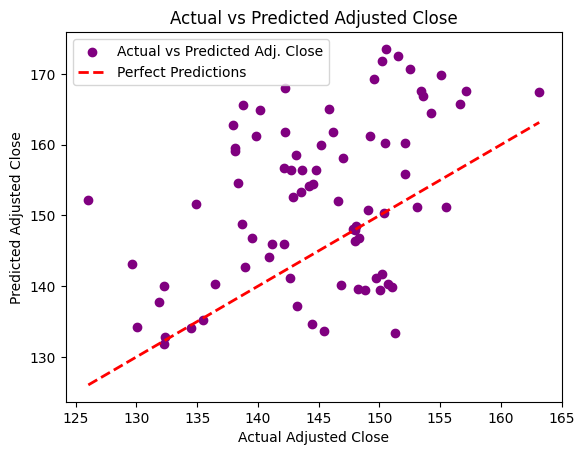

1/1 [==============================] - 0s 19ms/step
January 1st 2031 prediction: [[915.49243]]
  1/103 [..............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


103/103 [==============================] - 0s 2ms/step


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = keras.Sequential();

model.add(keras.layers.Dense(6, activation='relu', input_shape=(6,)))
model.add(keras.layers.Dense(6, activation='relu'))
model.add(Dropout(0.2))  # Add dropout layer
model.add(keras.layers.Dense(6, activation='relu'))
model.add(Dropout(0.2))  # Add dropout layer
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

df_aapl['Target Date'] = df_aapl['Date'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl_non = df_aapl.dropna()

# Specify the date to split the data
split_date = '2012-9-01'

# Convert the date column to datetime format if needed
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < split_date]
test_set = df_aapl[df_aapl['Date'] >= split_date]

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS', 'Target Date'], axis=1)

y_test_dnn = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS', 'Target Date'], axis=1)

# Create a StandardScaler
scaler = StandardScaler()
# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Fit model and include early stopping to prevent overfitting
model.fit(X_train_scaled, y_train, epochs=150, callbacks=[keras.callbacks.EarlyStopping(patience=5)])

y_pred_dnn = model.predict(X_test_scaled)

# Create a DataFrame to display actual values and predictions
results_df_dnn = pd.DataFrame({'Predicted': y_pred_dnn.flatten(), 'Actual': y_test_dnn})

# Plot the predictions and actual results
plt.scatter(results_df_dnn['Actual'], results_df_dnn['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df_dnn['Actual'].min(), results_df_dnn['Actual'].max()], [results_df_dnn['Actual'].min(), results_df_dnn['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

# Custom predictor below (takes in Open,High,Low,Close,Volume,Earnings)
fut_data = np.array([134.080002,134.740005,131.720001,132.690002,99116600,0])
fut_data_scaled = scaler.transform(fut_data.reshape(1,6))
y_pred_fut = model.predict(fut_data_scaled.reshape(1,6), batch_size=1)
print(f"January 1st 2031 prediction: {y_pred_fut}")

df_aapl_total = pd.read_csv('AAPL.csv')

df_aapl_total = df_aapl_total.dropna(subset=['Date'])

X_aapl_total = df_aapl_total.drop(['Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Create a new value for all predictions (ranging through 2032)
X_total_scaled = scaler.transform(X_aapl_total)

predictions_total = model.predict(X_total_scaled)
results_total_df_dnn = pd.DataFrame({'Predicted': predictions_total.flatten()})
results_total_df_dnn['Date'] = df_aapl_total['Date']
results_total_df_dnn['Target Date'] = results_total_df_dnn['Date'].shift(-2520)

# A Visual Between Actual Values, Linear Regressor, and DNN

How well do the trends line up? For the latter half of 2022 ranging from September through December?

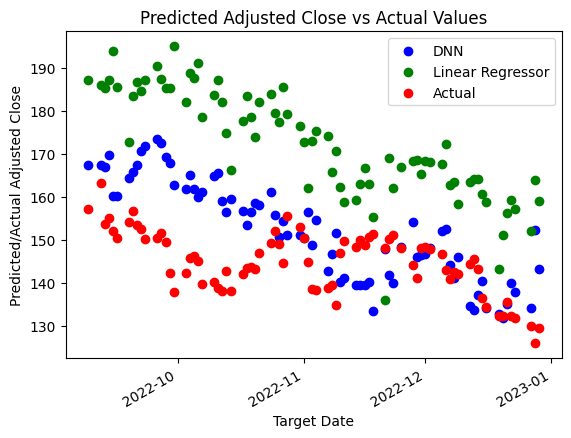

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

results_df_dnn = pd.DataFrame({'Predicted': y_pred_dnn.flatten(), 'Actual': y_test_dnn, 'Target Date': test_set['Target Date']})

# Filter out rows where 'Target Date' is not None
results_df_dnn = results_df_dnn.dropna(subset=['Target Date'])

results_df_lr = results_df_lr.dropna(subset=['Actual'])

# Convert 'Target Date' to datetime format
results_df_dnn['Target Date'] = pd.to_datetime(results_df_dnn['Target Date'])

# Plot only DNN predictions
plt.scatter(results_df_dnn['Target Date'], results_df_dnn['Predicted'], color='blue', label='DNN')

# Plot only LR predictions
plt.scatter(results_df_dnn['Target Date'], results_df_lr['Predicted'], color='green', label='Linear Regressor')

# Plot actual values
plt.scatter(results_df_dnn['Target Date'], results_df_dnn['Actual'], color='red', label='Actual')

plt.xlabel('Target Date')
plt.ylabel('Predicted/Actual Adjusted Close')
plt.title('Predicted Adjusted Close vs Actual Values')
plt.legend()

# Set x-axis ticks to show only each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.gcf().autofmt_xdate()  # Rotate date labels for better visibility

plt.show()


# What about through the end of 2032?

       Predicted       Date Target Date
0      88.756996 2010-01-04  2020-01-04
1      84.869942 2010-01-05  2020-01-05
2      85.727112 2010-01-06  2020-01-06
3      88.657425 2010-01-07  2020-01-07
4      90.473259 2010-01-08  2020-01-08
...          ...        ...         ...
3266  910.201294 2022-12-22  2032-12-22
3267  907.363098 2022-12-23  2032-12-23
3268  895.560486 2022-12-27  2032-12-27
3269  868.162292 2022-12-28  2032-12-28
3270  892.141541 2022-12-29  2032-12-29

[3271 rows x 3 columns]
3271
3271
3271


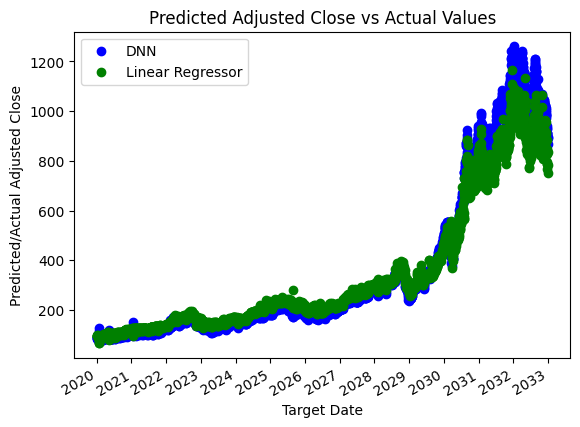

In [ ]:
# Assuming results_total_df_dnn is your DataFrame
results_total_df_dnn['Date'] = pd.to_datetime(results_total_df_dnn['Date'])  # Convert 'Date' to datetime if not already
results_total_df_dnn['Target Date'] = pd.to_datetime(results_total_df_dnn['Target Date'], errors='coerce')  # Convert 'Target Date' to datetime

# Calculate the time difference (10 years) to shift the 'Date' column
time_difference = pd.DateOffset(years=10)

# Update 'Target Date' based on the pattern
results_total_df_dnn['Target Date'] = results_total_df_dnn['Date'] + time_difference

# If you want to replace 'NaT' (Not a Time) with 'None' (optional step)
results_total_df_dnn['Target Date'] = results_total_df_dnn['Target Date'].where(results_total_df_dnn['Target Date'].notna(), None)




print(results_total_df_dnn)

# Plot only DNN predictions
plt.scatter(results_total_df_dnn['Target Date'], results_total_df_dnn['Predicted'], color='blue', label='DNN')

print(len(results_total_df_lr[['Predicted']]))
print(len(results_total_df_dnn['Target Date']))
print(len(results_total_df_dnn['Predicted']))

# Plot only LR predictions
plt.scatter(results_total_df_dnn['Target Date'], results_total_df_lr['Predicted'], color='green', label='Linear Regressor')

# # Plot actual values
# plt.scatter(results_df_dnn['Target Date'], results_df_dnn['Actual'], color='red', label='Actual')

plt.xlabel('Target Date')
plt.ylabel('Predicted/Actual Adjusted Close')
plt.title('Predicted Adjusted Close vs Actual Values')
plt.legend()

# Set x-axis ticks to show only each year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()  # Rotate date labels for better visibility

plt.show()

# Seem suspiciously close to the shape of Covid below?

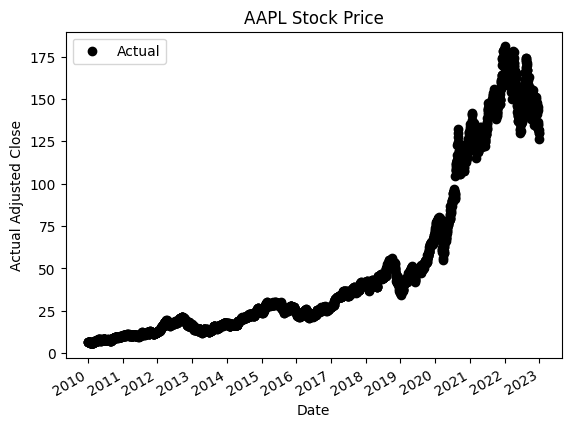

In [ ]:
# Plot of AAPL from 2010-2022
plt.scatter(df_aapl['Date'], df_aapl['Adj Close'], color='black', label='Actual')

plt.xlabel('Date')
plt.ylabel('Actual Adjusted Close')
plt.title('AAPL Stock Price')
plt.legend()

# Set x-axis ticks to show only each year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()

plt.show()

Yeah, so it turns out the the LR and FNN ended up predicting the next decade as inspired by Covid, incredibly well, but not so great in terms of the shape of what the actual future graph of what AAPL stock will look like.